In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import importlib

In [20]:
# for debug
import jpeg_table
importlib.reload(jpeg_table)

# テーブル読み込み
TBL_L_Q = jpeg_table.table_luminance_quantization
TBL_C_Q = jpeg_table.table_chrominance_quantization
TBL_L_DC = jpeg_table.table_luminance_dc
TBL_C_DC = jpeg_table.table_chrominance_dc
TBL_L_AC = jpeg_table.table_luminance_ac
TBL_C_AC = jpeg_table.table_chrominance_ac
TBL_DCT = jpeg_table.table_dct
TBL_IDCT = jpeg_table.table_idct
TBL_ZIGZAG = jpeg_table.table_zigzag

DEC_L_DC = jpeg_table.decode_luminance_dc
DEC_C_DC = jpeg_table.decode_chrominance_dc
DEC_L_AC = jpeg_table.decode_luminance_ac
DEC_C_AC = jpeg_table.decode_chrominance_ac

In [21]:
Q = 12
QV = 2**Q

In [22]:
R = np.ndarray((8), dtype=np.int64)
for i in range(8):
    R[i] = int(np.cos(i / 16.0 * np.pi) * np.sqrt(2.0) * QV)
INVSQRT2 = int(1.0 / np.sqrt(2.0) * QV)

def llm_dct_8(x):
    x = np.array(x).astype(np.int64)
    y = np.ndarray((8), dtype=np.int64)
    c1 = x[0]; c2 = x[7]; t0 = c1 + c2; t7 = c1 - c2
    c1 = x[1]; c2 = x[6]; t1 = c1 + c2; t6 = c1 - c2
    c1 = x[2]; c2 = x[5]; t2 = c1 + c2; t5 = c1 - c2
    c1 = x[3]; c2 = x[4]; t3 = c1 + c2; t4 = c1 - c2
    c0 = t0 + t3; c3 = t0 - t3
    c1 = t1 + t2; c2 = t1 - t2
    y[0] = c0 + c1
    y[4] = c0 - c1
    y[2] = c2 * R[6] // QV + c3 * R[2] // QV
    y[6] = c3 * R[6] // QV - c2 * R[2] // QV
    c3 = t4 * R[3] // QV + t7 * R[5] // QV
    c0 = t7 * R[3] // QV - t4 * R[5] // QV
    c2 = t5 * R[1] // QV + t6 * R[7] // QV
    c1 = t6 * R[1] // QV - t5 * R[7] // QV
    y[5] = c3 - c1; y[3] = c0 - c2
    c0 = (c0 + c2) * INVSQRT2 // QV
    c3 = (c3 + c1) * INVSQRT2 // QV
    y[1] = c0 + c3; y[7] = c0 - c3
    for i in range(8):
        y[i] = y[i] * INVSQRT2 // QV // 2
    return y

def llm_dct_8x8(src):
    dst = np.ndarray((8, 8))
    for i in range(8):
        dst[i, :] = llm_dct_8(src[i, :])
    for i in range(8):
        dst[:, i] = llm_dct_8(dst[:, i])
    return dst

def calc_llm_dct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            dst[yi:yi+8, xi:xi+8] = llm_dct_8x8(src[yi:yi+8, xi:xi+8])
    return dst

def llm_idct_8(y):
    y = np.array(y).astype(np.int64)
    x = np.ndarray((8), dtype=np.int64)
    z0 = y[1] + y[7]; z1 = y[3] + y[5]; z2 = y[3] + y[7]; z3 = y[1] + y[5]
    z4 = (z0 + z1) * R[3] // QV
    z0 = z0 * (-R[3] + R[7]) // QV
    z1 = z1 * (-R[3] - R[1]) // QV
    z2 = z2 * (-R[3] - R[5]) // QV + z4
    z3 = z3 * (-R[3] + R[5]) // QV + z4
    b3 = y[7] * (-R[1] + R[3] + R[5] - R[7]) // QV + z0 + z2
    b2 = y[5] * ( R[1] + R[3] - R[5] + R[7]) // QV + z1 + z3
    b1 = y[3] * ( R[1] + R[3] + R[5] - R[7]) // QV + z1 + z2
    b0 = y[1] * ( R[1] + R[3] - R[5] - R[7]) // QV + z0 + z3
    z4 = (y[2] + y[6]) * R[6] // QV
    z0 = y[0] + y[4]; z1 = y[0] - y[4]
    z2 = z4 - y[6] * (R[2] + R[6]) // QV
    z3 = z4 + y[2] * (R[2] - R[6]) // QV
    a0 = z0 + z3; a3 = z0 - z3
    a1 = z1 + z2; a2 = z1 - z2
    x[0] = a0 + b0; x[7] = a0 - b0
    x[1] = a1 + b1; x[6] = a1 - b1
    x[2] = a2 + b2; x[5] = a2 - b2
    x[3] = a3 + b3; x[4] = a3 - b3
    for i in range(8):
        x[i] = x[i] * INVSQRT2 // QV // 2
    return x

def llm_idct_8x8(src):
    dst = np.ndarray((8, 8))
    for i in range(8):
        dst[i, :] = llm_idct_8(src[i, :])
    for i in range(8):
        dst[:, i] = llm_idct_8(dst[:, i])
    return dst

def calc_llm_idct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            dst[yi:yi+8, xi:xi+8] = llm_idct_8x8(src[yi:yi+8, xi:xi+8])
    return dst

def bit_size(n):
    if n == 0: return 0
    if n >= -1 and n <= 1: return 1
    if n >= -3 and n <= 3: return 2
    if n >= -7 and n <= 7: return 3
    if n >= -15 and n <= 15: return 4
    if n >= -31 and n <= 31: return 5
    if n >= -63 and n <= 63: return 6
    if n >= -127 and n <= 127: return 7
    if n >= -255 and n <= 255: return 8
    if n >= -511 and n <= 511: return 9
    if n >= -1023 and n <= 1023: return 10
    if n >= -2047 and n <= 2047: return 11
    if n >= -4095 and n <= 4095: return 12
    assert(0)

def encode_value(v, size):
    if v < 0:
        v -= 1
    return v & (2**size - 1)

def decode_value(v, size):
    if v >= 2**size // 2:
        return v
    else:
        return v - (2**size - 1)

class BitStream:
    def __init__(self):
        self.stream = []
        self.data = 0
        self.size = 0
    
    def push(self, data, size):
        data = int(data)
        data &= 2**size - 1
        self.data <<= size
        self.data |= data
        self.size += size
    
    def pop(self, bits):
        v = self.data >> (self.size - bits)
        self.size -= bits
        self.data &= 2**self.size - 1
        return v
    
    def head(self, bits=16):
        if self.size > bits:
            return self.data >> (self.size - bits)
        else:
            return self.data << (bits - self.size)
    
    def push_ac(self, tbl, run, value):
        while run >= 16:
            self.push(tbl[15][0]['code'], tbl[15][0]['length'])
            run -= 16
        size = bit_size(value)
        self.push(tbl[run][size]['code'], tbl[run][size]['length'])
        self.push(encode_value(value, size), size)

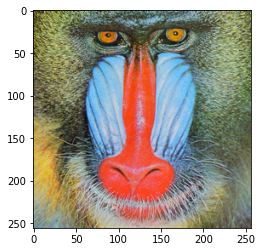

In [23]:
# ファイル読み込み
img_src = cv2.imread("Mandrill.bmp")
w = img_src.shape[1]
h = img_src.shape[0]
plt.imshow(img_src[:,:,::-1])

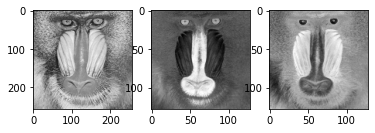

In [24]:
# YCbCr化 (色相は縮小)
img_ycrcb = cv2.cvtColor(img_src, cv2.COLOR_BGR2YCrCb)
img_y = img_ycrcb[:,:,0]
img_cr = cv2.resize(img_ycrcb[:,:,1], (w//2, h//2))
img_cb = cv2.resize(img_ycrcb[:,:,2], (w//2, h//2))

# 表示
plt.subplot(131)
plt.imshow(img_y, 'gray')
plt.subplot(132)
plt.imshow(img_cr, 'gray')
plt.subplot(133)
plt.imshow(img_cb, 'gray')

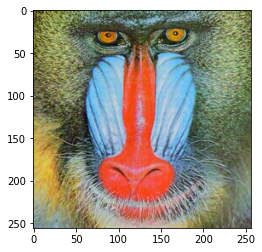

In [25]:
# dct
offset = 128
dct_y = calc_llm_dct(img_y.astype(np.int64) - offset)
dct_cr = calc_llm_dct(img_cr.astype(np.int64) - offset)
dct_cb = calc_llm_dct(img_cb.astype(np.int64) - offset)

# test
if True:
    # 戻るかチェック
    tmp_y = np.clip(calc_llm_idct(dct_y) + 128, 0, 255).astype(np.uint8)
    tmp_cr = np.clip(calc_llm_idct(dct_cr) + 128, 0, 255).astype(np.uint8)
    tmp_cb = np.clip(calc_llm_idct(dct_cb) + 128, 0, 255).astype(np.uint8)
    tmp_cr = cv2.resize(tmp_cr, (w, h))
    tmp_cb = cv2.resize(tmp_cb, (w, h))
    tmp_ycrcb = cv2.merge([tmp_y, tmp_cr, tmp_cb])
    tmp_rgb = cv2.cvtColor(tmp_ycrcb, cv2.COLOR_YCrCb2BGR)
    plt.imshow(tmp_rgb[:,:,::-1])

In [26]:
dct_y

array([[-334.,  -78.,  -28., ...,  -15.,    1.,   -3.],
       [ -20.,  106.,   31., ...,  -10.,   -1.,    0.],
       [ -22.,   16.,   -4., ...,  -25.,  -31.,   26.],
       ...,
       [   4.,   -9.,    1., ...,    0.,   -4.,   -1.],
       [ -14.,    2.,    3., ...,    2.,   -7.,   -3.],
       [  11.,    1.,   -4., ...,    3.,   -1.,    2.]])

In [27]:
# 量子化
dct_y_q = np.zeros_like(dct_y)
dct_cr_q = np.zeros_like(dct_cr)
dct_cb_q = np.zeros_like(dct_cb)
for yi in range(0, h, 8):
    for xi in range(0, w, 8):
      dct_y_q[yi:yi+8, xi:xi+8] = np.round(dct_y[yi:yi+8, xi:xi+8] / TBL_L_Q)
for yi in range(0, h//2, 8):
    for xi in range(0, w//2, 8):
       dct_cr_q[yi:yi+8, xi:xi+8] = np.round(dct_cr[yi:yi+8, xi:xi+8] / TBL_C_Q)
       dct_cb_q[yi:yi+8, xi:xi+8] = np.round(dct_cb[yi:yi+8, xi:xi+8] / TBL_C_Q)

dct_y_q = dct_y_q.astype(np.int32)
dct_cr_q = dct_cr_q.astype(np.int32)
dct_cb_q = dct_cb_q.astype(np.int32)

In [28]:
def encode_block(dct_q, enc_tbl):
    # ジグザグスキャン
    dct_q = dct_q.astype(np.int16)
    ziqzag = []
    for p in TBL_ZIGZAG:
        ziqzag.append(dct_q[p[1]][p[0]])

    # encode
    bs = BitStream()
    run = 0
    for v in ziqzag:
        if v == 0:
            run += 1
        else:
            bs.push_ac(enc_tbl, run, v)
            run = 0
    if run > 0:
        bs.push_ac(enc_tbl, 0, 0)

    return bs

def encode(dct_q, enc_tbl):
    w = dct_q.shape[1]
    h = dct_q.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    bs = []
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            bs.append(encode_block(dct_q[yi:yi+8, xi:xi+8], enc_tbl))
    return bs


def decode_block(bs, dec_tbl):
    dec_data = []
    while len(dec_data) < 64:
        c = dec_tbl[bs.head()]
        if c['run'] == 0 and c['size'] == 0:
            while len(dec_data) < 64:
                dec_data.append(0)
            break
            
        for _ in range(c['run']):
            dec_data.append(0)
        bs.pop(c['length'])
        v = bs.pop(c['size'])
        v = decode_value(v, c['size'])
        dec_data.append(v)
    
    # ジグザグ
    dst = np.ndarray((8, 8), dtype=np.int16)
    for y in range(8):
        for x in range(8):
            dst[y][x] = dec_data[jpeg_table.tbl_zigzag[y][x]]

    return dst


def decode(w, h, bs, dec_tbl):
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    assert(len(bs) == (w//8) * (h//8))
    idx = 0
    dst = np.ndarray((h, w), dtype=np.int16)
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            dst[yi:yi+8, xi:xi+8] = decode_block(bs[idx], dec_tbl)
            idx += 1
    return dst

In [29]:
# ハフマン符号化
bs_y = encode(dct_y_q, TBL_L_AC)
bs_cr = encode(dct_cr_q, TBL_C_AC)
bs_cb = encode(dct_cb_q, TBL_C_AC)

In [30]:
size = 0
for bs in bs_y:
    size += bs.size
for bs in bs_cr:
    size += bs.size
for bs in bs_cb:
    size += bs.size
print(size / 8)

12741.875


In [31]:
# ハフマン復号
dec_dct_y_q = decode(256, 256, bs_y, jpeg_table.decode_luminance_ac)
dec_dct_cr_q = decode(128, 128, bs_cr, jpeg_table.decode_chrominance_ac)
dec_dct_cb_q = decode(128, 128, bs_cb, jpeg_table.decode_chrominance_ac)

In [32]:
# 逆量子化
dct_y_iq = dec_dct_y_q.copy()
dct_cr_iq = dec_dct_cr_q.copy()
dct_cb_iq = dec_dct_cb_q.copy()
for yi in range(0, h, 8):
    for xi in range(0, w, 8):
        dct_y_iq[yi:yi+8, xi:xi+8] *= TBL_L_Q
for yi in range(0, h//2, 8):
    for xi in range(0, w//2, 8):
        dct_cr_iq[yi:yi+8, xi:xi+8] *= TBL_C_Q
        dct_cb_iq[yi:yi+8, xi:xi+8] *= TBL_C_Q

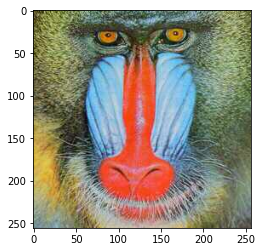

In [33]:
# 逆DCT
idct_y = np.clip(calc_llm_idct(dct_y_iq) + offset, 0, 255).astype(np.uint8)
idct_cr = np.clip(calc_llm_idct(dct_cr_iq) + offset, 0, 255).astype(np.uint8)
idct_cb = np.clip(calc_llm_idct(dct_cb_iq) + offset, 0, 255).astype(np.uint8)

# 色相をリサイズ
idct_cr = cv2.resize(idct_cr, (w, h))
idct_cb = cv2.resize(idct_cb, (w, h))

# 表示
idct_ycrcb = cv2.merge([idct_y, idct_cr, idct_cb])
idct_rgb = cv2.cvtColor(idct_ycrcb, cv2.COLOR_YCrCb2BGR)
plt.imshow(idct_rgb[:,:,::-1])